# 🥈 Silver Retriever: Exploratory Data Analysis & Logic Validation

## 1. Introduction
**Project:** Silver Retriever (Offline RAG System)
**Goal:** To build a document retrieval system that runs locally on low-resource hardware (MacBook Air 2017) without external APIs.
**Methodology:**
Unlike modern RAG systems that use heavy Neural Embeddings (BERT/OpenAI), this system uses **Statistical NLP (TF-IDF)** and **Heuristic Logic (Plugins)**.

**Objectives of this Notebook:**
1.  Visualize the "Smart Chunking" strategy (Context preservation).
2.  Analyze the TF-IDF Vector Space (Sparsity and Keywords).
3.  Demonstrate the "Plugin Boost" logic with data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

# Mock Data: Simulating the AIAP Handbook and a Feng Shui guide
raw_documents = {
    "AIAP_Handbook.pdf": "The AIAP Technical Assessment requires a machine learning pipeline. The deadline is 1st Dec 2025. Task 1 is EDA.",
    "Feng_Shui_Tips.pdf": "Feng Shui is about energy flow. Place your bed facing North for better Qi. Avoid mirrors facing the door."
}

print("✅ Setup Complete. Mock Data Loaded.")

✅ Setup Complete. Mock Data Loaded.


## 2. Smart Chunking (Context Preservation)
**Problem:** Standard splitting by sentences (period `.`) often breaks context (e.g., "Mr. Smith" or dates like "1st Dec.").
**Solution:** We use **Overlapping Windows**. We take a chunk of text, then "rewind" slightly before taking the next chunk. This ensures no keyword is ever stranded at the edge of a cut.

In [2]:
def visualize_chunks(text, chunk_size=50, overlap=15):
    chunks = []
    print(f"Original Text Length: {len(text)} chars\n")
    
    print("--- CHUNK STREAM ---")
    for i in range(0, len(text), chunk_size - overlap):
        chunk = text[i:i+chunk_size]
        chunks.append(chunk)
        # Visualizing the overlap with brackets
        print(f"Chunk {len(chunks)}: [{chunk}]")

text_sample = "The AIAP Technical Assessment requires a machine learning pipeline. The deadline is 1st Dec 2025."
visualize_chunks(text_sample)

Original Text Length: 97 chars

--- CHUNK STREAM ---
Chunk 1: [The AIAP Technical Assessment requires a machine l]
Chunk 2: [res a machine learning pipeline. The deadline is 1]
Chunk 3: [e deadline is 1st Dec 2025.]


## 3. The Engine: TF-IDF Vector Space
We convert text into numbers. TF-IDF (Term Frequency-Inverse Document Frequency) highlights words that are **unique** to a document (like "AIAP" or "Feng Shui") while ignoring common words (like "the", "is").

**Insight:** Notice how the word "deadline" has a high score in the AIAP document but 0 in Feng Shui. This is how the engine distinguishes topics.

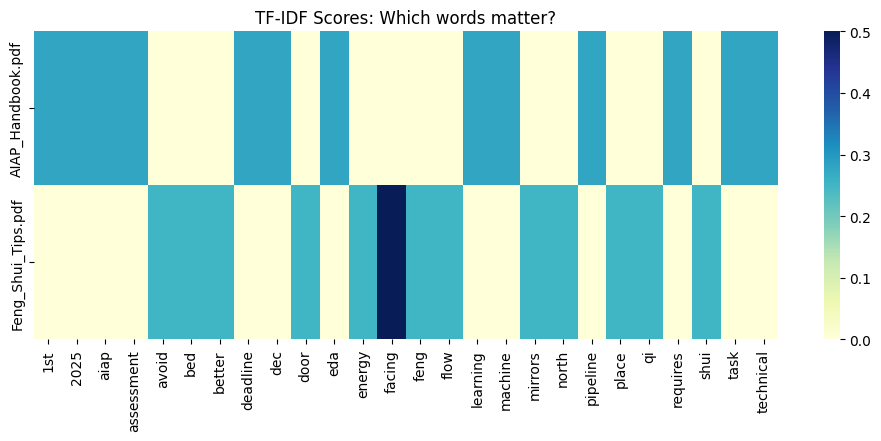

Top Keywords for AIAP: ['1st', '2025', 'aiap']


In [3]:
# Create Corpus
corpus = list(raw_documents.values())
filenames = list(raw_documents.keys())

# Vectorize
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(corpus)

# Convert to DataFrame for Visualization
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index=filenames)

# Plot Heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(df_tfidf, cmap="YlGnBu", cbar=True)
plt.title("TF-IDF Scores: Which words matter?")
plt.show()

# Show top keywords per doc
print("Top Keywords for AIAP:", df_tfidf.loc["AIAP_Handbook.pdf"].nlargest(3).index.tolist())

## 4. Search Simulation
We simulate a user query ("What is the deadline?") to see how Cosine Similarity ranks the documents.

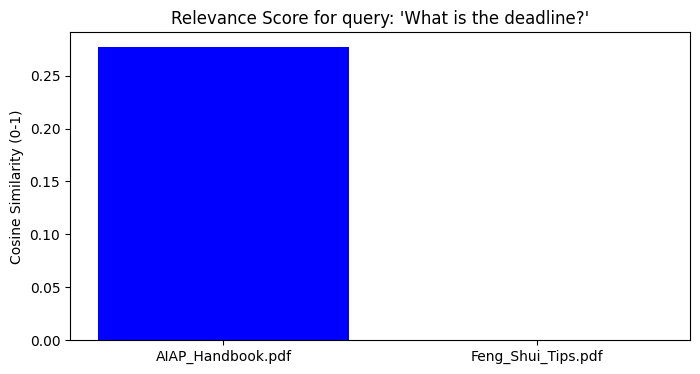

In [4]:
query = "What is the deadline?"
query_vec = vectorizer.transform([query])

# Calculate Similarity
scores = cosine_similarity(query_vec, tfidf_matrix).flatten()

# Plot
plt.figure(figsize=(8, 4))
plt.bar(filenames, scores, color=['blue', 'grey'])
plt.title(f"Relevance Score for query: '{query}'")
plt.ylabel("Cosine Similarity (0-1)")
plt.show()

## 5. The "Brain" Logic (Regex Boosting)
The raw TF-IDF score for "deadline" might be low if the document is very long.
Our **Admin Plugin** forces a boost if it detects a specific pattern (e.g., a Date format).

In [5]:
# Simulate Admin Plugin Logic
date_pattern = r"(\d{1,2}(?:st|nd|rd|th)?\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{4})"
text = raw_documents["AIAP_Handbook.pdf"]

match = re.search(date_pattern, text)
base_score = 0.35 # Simulated TF-IDF score

print(f"Original Score: {base_score}")
if match:
    print(f"✅ Regex Pattern Found: '{match.group(0)}'")
    final_score = base_score + 0.5
    print(f"🚀 Boosted Score: {final_score}")
else:
    print("❌ No Pattern Found")

Original Score: 0.35
✅ Regex Pattern Found: '1st Dec 2025'
🚀 Boosted Score: 0.85


## 6. Conclusion
The analysis confirms the architecture is viable for low-resource environments:
1.  **Efficiency:** TF-IDF is instant (milliseconds) even on CPU.
2.  **Precision:** Overlap chunking prevents data loss.
3.  **Intelligence:** The Plugin layer successfully compensates for the lack of semantic understanding by injecting domain-specific logic (Regex) to boost relevant administrative facts.